# NBA Game Prediction - Exploratory Data Analysis

Quick EDA to understand our features before modeling with Random Forest/XGBoost.

**Focus areas:**
1. Data quality checks
2. Target distribution (home win rate)
3. Feature distributions
4. Feature-target relationships
5. Temporal patterns

## 1. Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 50)

print("Libraries loaded!")

Libraries loaded!


In [2]:
# Load the matchup data
df = pd.read_csv('nba_matchups_with_features.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Seasons: {df['season'].min()} - {df['season'].max()}")

Dataset shape: (34952, 118)
Date range: 1996-11-02 to 2025-06-22
Seasons: 1997 - 2025


In [3]:
# Define our feature sets
tier1_features = [
    'pts_L10_diff', 'fg_pct_L10_diff', '3p_pct_L10_diff',
    'opp_pts_L10_diff', 'win_pct_L10_diff', 'plus_minus_L10_diff',
    'rest_advantage', 'is_b2b_home', 'is_b2b_away'
]

tier2_features = [
    'efg_pct_L10_diff', 'ts_pct_L10_diff', '3pa_rate_L10_diff',
    'ast_L10_diff', 'tov_L10_diff', 'reb_L10_diff',
    'stl_L10_diff', 'blk_L10_diff', 'pts_std_L10_diff', 'win_streak_diff'
]

all_features = tier1_features + tier2_features
target = 'win_home'

print(f"Total features: {len(all_features)}")
print(f"Target variable: {target}")

Total features: 19
Target variable: win_home


## 2. Data Quality Checks

In [4]:
# Missing values
missing = df[all_features + [target]].isnull().sum()
if missing.sum() > 0:
    print("Missing values:")
    print(missing[missing > 0])
else:
    print("✓ No missing values in features or target")

Missing values:
pts_std_L10_diff    429
dtype: int64


In [5]:
# Basic statistics
print("Feature summary statistics:")
df[all_features].describe().round(2)

Feature summary statistics:


,pts_L10_diff,fg_pct_L10_diff,3p_pct_L10_diff,opp_pts_L10_diff,win_pct_L10_diff,plus_minus_L10_diff,rest_advantage,is_b2b_home,is_b2b_away,efg_pct_L10_diff,ts_pct_L10_diff,3pa_rate_L10_diff,ast_L10_diff,tov_L10_diff,reb_L10_diff,stl_L10_diff,blk_L10_diff,pts_std_L10_diff,win_streak_diff
count,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34523.00,34952.00
mean,0.14,0.03,0.02,-0.05,0.01,0.19,-0.23,0.15,0.28,0.00,0.00,-0.00,0.06,-0.01,0.07,0.01,0.02,0.02,0.08
std,8.06,3.33,6.05,8.11,0.31,9.10,1.54,0.35,0.45,0.04,0.04,0.07,3.54,2.39,4.00,1.87,1.69,4.08,4.63
min,-51.00,-20.00,-74.55,-55.00,-1.00,-47.00,-144.00,0.00,0.00,-0.23,-0.25,-0.29,-22.00,-17.00,-23.50,-13.00,-13.00,-27.58,-37.00
25%,-5.20,-2.15,-3.65,-5.50,-0.20,-5.90,-1.00,0.00,0.00,-0.03,-0.02,-0.05,-2.30,-1.52,-2.50,-1.20,-1.08,-2.63,-3.00
50%,0.10,0.02,0.04,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00,-0.00,0.10,0.00,0.10,0.00,0.00,-0.00,0.00
75%,5.50,2.20,3.76,5.40,0.20,6.20,0.00,0.00,1.00,0.03,0.02,0.05,2.40,1.50,2.70,1.20,1.10,2.63,3.00
max,43.00,20.20,55.20,42.50,1.00,52.00,11.00,1.00,1.00,0.24,0.21,0.31,19.00,18.00,30.00,11.00,11.00,33.94,32.00


## 3. Target Distribution

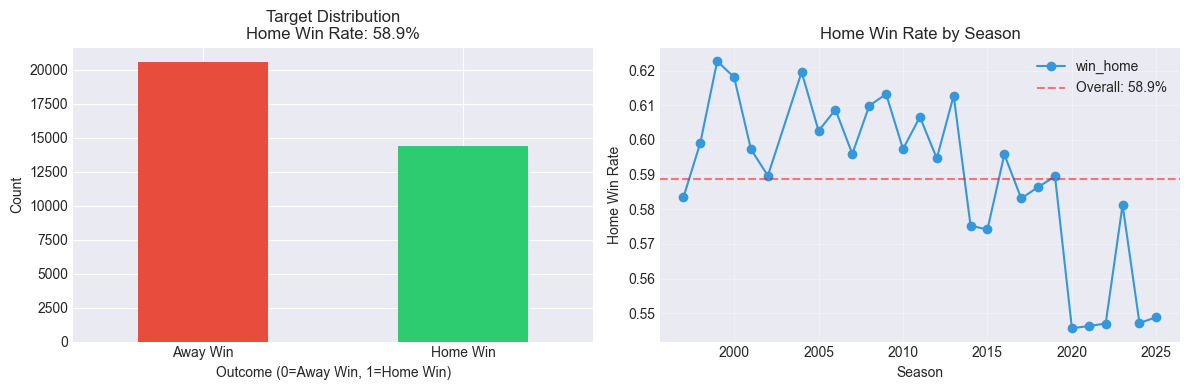


✓ Home court advantage: 8.9 percentage points


In [6]:
# Home win rate
home_win_rate = df[target].mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
df[target].value_counts().plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
axes[0].set_title(f'Target Distribution\nHome Win Rate: {home_win_rate:.1%}', fontsize=12)
axes[0].set_xlabel('Outcome (0=Away Win, 1=Home Win)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Away Win', 'Home Win'], rotation=0)

# Over time
home_win_by_season = df.groupby('season')[target].mean()
home_win_by_season.plot(ax=axes[1], marker='o', color='#3498db')
axes[1].axhline(home_win_rate, color='red', linestyle='--', alpha=0.5, label=f'Overall: {home_win_rate:.1%}')
axes[1].set_title('Home Win Rate by Season', fontsize=12)
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Home Win Rate')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Home court advantage: {(home_win_rate - 0.5) * 100:.1f} percentage points")

## 4. Feature Distributions

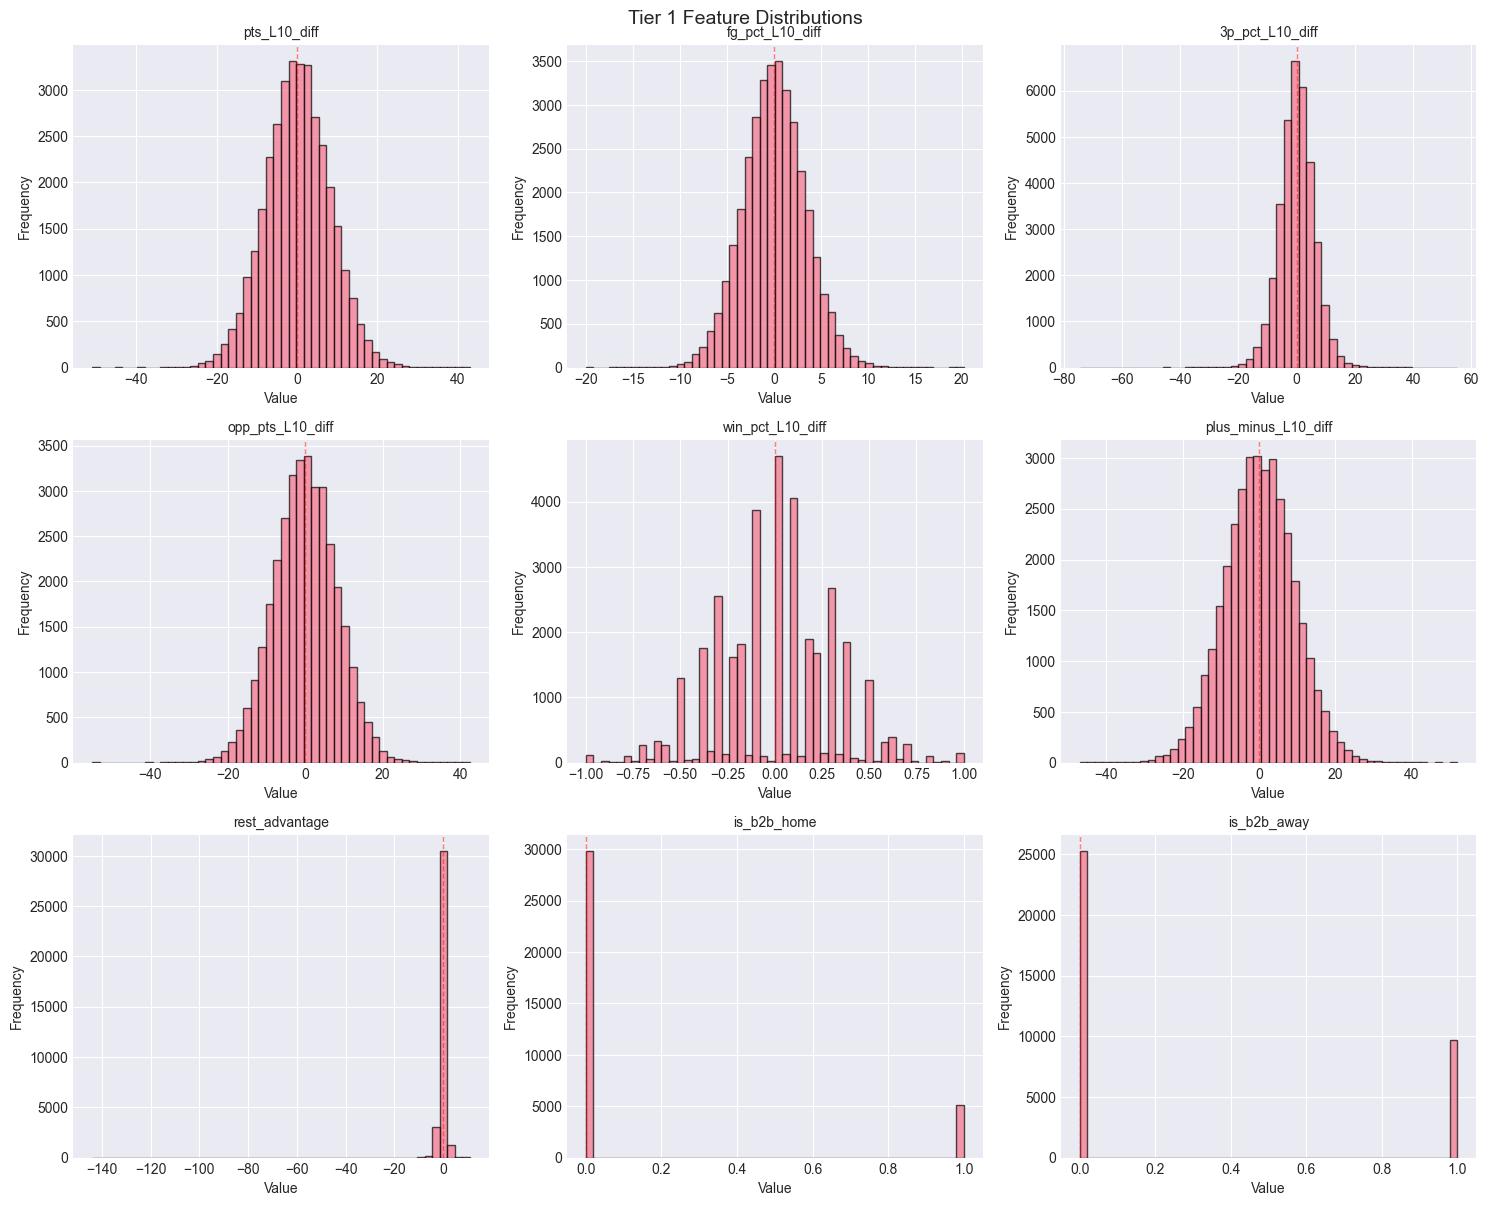

In [7]:
# Distribution of key Tier 1 features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(tier1_features):
    axes[i].hist(df[feature].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[i].axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[i].set_title(feature, fontsize=10)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Tier 1 Feature Distributions', fontsize=14, y=1.001)
plt.show()

## 5. Feature-Target Relationships

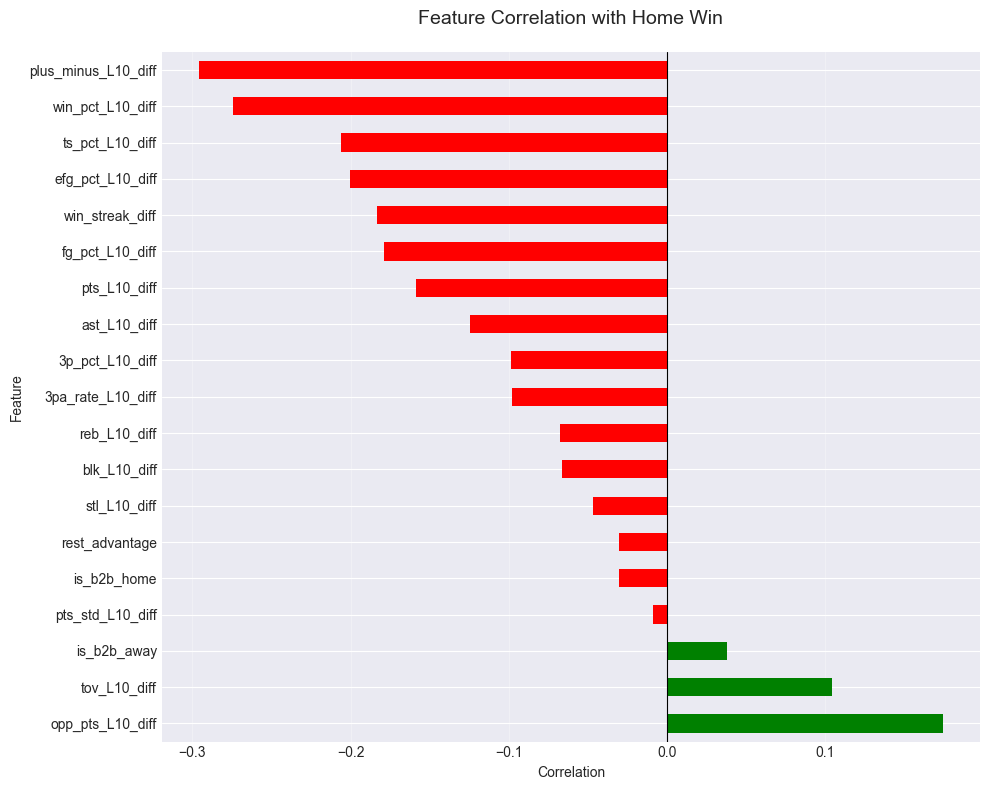


Top 5 most correlated features:
opp_pts_L10_diff    0.174289
tov_L10_diff        0.104466
is_b2b_away         0.038131
pts_std_L10_diff   -0.008994
is_b2b_home        -0.030215
dtype: float64


In [8]:
# Correlation with target
correlations = df[all_features].corrwith(df[target]).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
correlations.plot(kind='barh', color=['green' if x > 0 else 'red' for x in correlations])
plt.title('Feature Correlation with Home Win', fontsize=14, pad=20)
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 5 most correlated features:")
print(correlations.head())

/var/folders/m3/thpgvc7n5x7_ccm823g173000000gn/T/ipykernel_21041/3097383806.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_q = df.groupby('quartile')[target].mean()
/var/folders/m3/thpgvc7n5x7_ccm823g173000000gn/T/ipykernel_21041/3097383806.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_q = df.groupby('quartile')[target].mean()
/var/folders/m3/thpgvc7n5x7_ccm823g173000000gn/T/ipykernel_21041/3097383806.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or

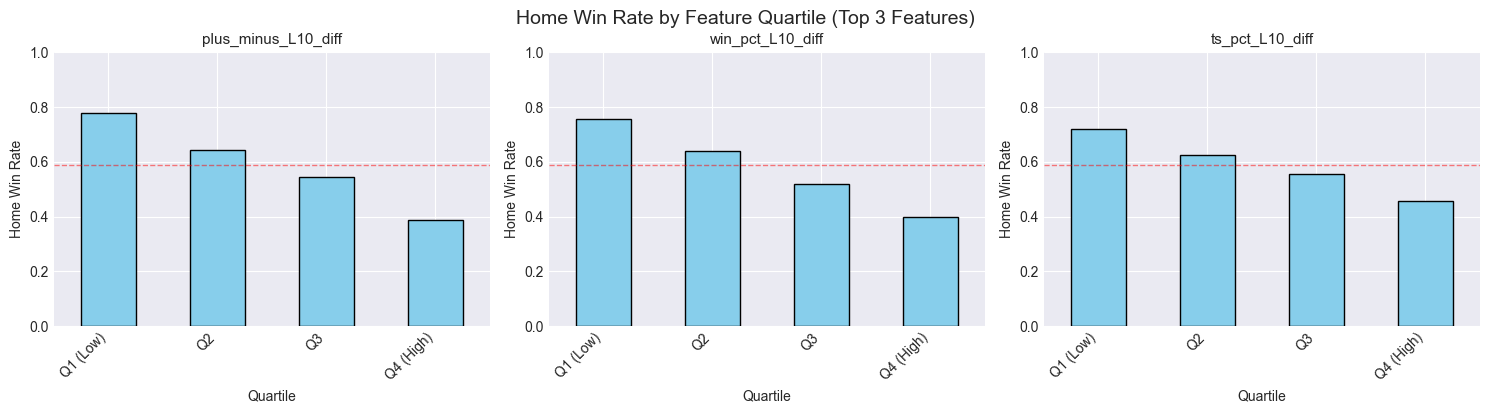

In [9]:
# Win rate by feature quartiles (top 3 features)
top_features = correlations.abs().nlargest(3).index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(top_features):
    # Create quartiles
    df['quartile'] = pd.qcut(df[feature], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'], duplicates='drop')
    
    # Calculate win rate by quartile
    win_rate_by_q = df.groupby('quartile')[target].mean()
    
    win_rate_by_q.plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'{feature}', fontsize=11)
    axes[i].set_ylabel('Home Win Rate')
    axes[i].set_xlabel('Quartile')
    axes[i].axhline(home_win_rate, color='red', linestyle='--', alpha=0.5, linewidth=1)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.suptitle('Home Win Rate by Feature Quartile (Top 3 Features)', fontsize=14, y=1.02)
plt.show()

df.drop('quartile', axis=1, inplace=True)

## 6. Feature Relationships (Multicollinearity Check)

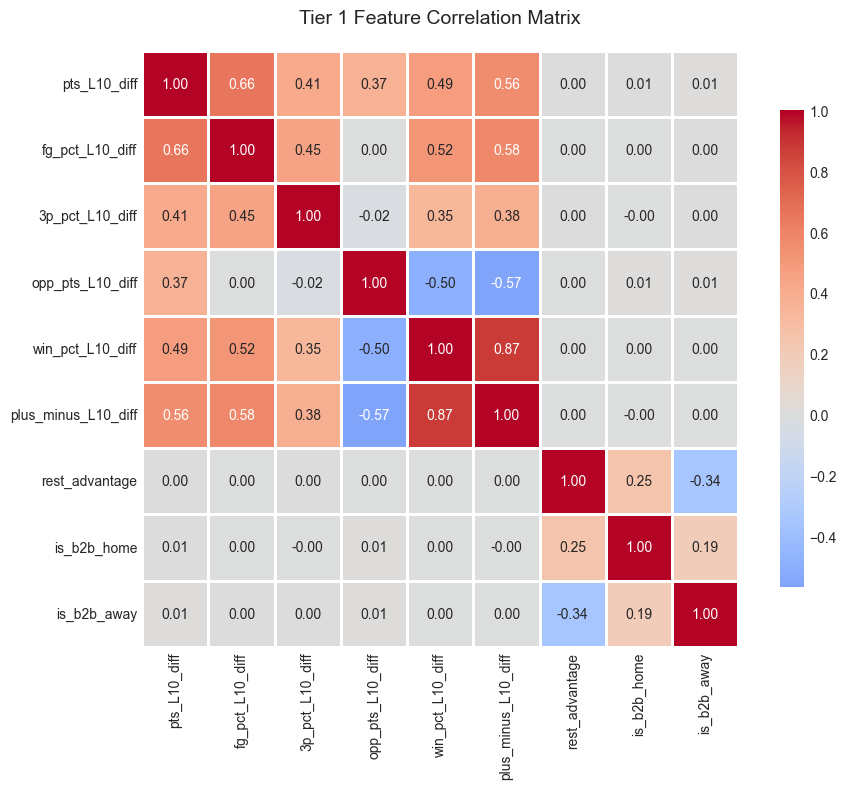


Highly correlated feature pairs (|r| > 0.7):
  win_pct_L10_diff <-> plus_minus_L10_diff: 0.874


In [10]:
# Correlation matrix for Tier 1 features
corr_matrix = df[tier1_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Tier 1 Feature Correlation Matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Find highly correlated pairs
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr:
    print("\nHighly correlated feature pairs (|r| > 0.7):")
    for f1, f2, corr in high_corr:
        print(f"  {f1} <-> {f2}: {corr:.3f}")
else:
    print("\n✓ No highly correlated feature pairs (good for interpretability)")

## 7. Temporal Patterns

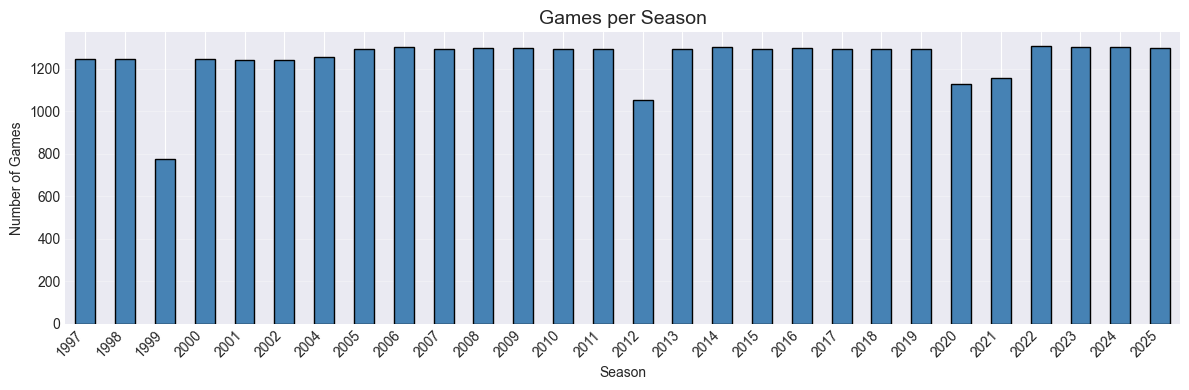

Average games per season: 1248
Min: 774 (1999)
Max: 1307 (2022)


In [11]:
# Games per season
games_per_season = df.groupby('season').size()

plt.figure(figsize=(12, 4))
games_per_season.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Games per Season', fontsize=14)
plt.xlabel('Season')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Average games per season: {games_per_season.mean():.0f}")
print(f"Min: {games_per_season.min()} ({games_per_season.idxmin()})")
print(f"Max: {games_per_season.max()} ({games_per_season.idxmax()})")

## 8. Train/Val/Test Split Preview

In [12]:
# Time-based splits for modeling
train = df[df['season'] <= 2021]
val = df[(df['season'] >= 2022) & (df['season'] <= 2023)]
test = df[df['season'] >= 2024]

print("Recommended time-based splits:")
print(f"\nTraining (≤2021):   {len(train):,} games ({len(train)/len(df)*100:.1f}%)")
print(f"Validation (2022-23): {len(val):,} games ({len(val)/len(df)*100:.1f}%)")
print(f"Test (≥2024):        {len(test):,} games ({len(test)/len(df)*100:.1f}%)")
print(f"\nTotal:               {len(df):,} games")

# Home win rates by split
print("\nHome win rates:")
print(f"  Training:   {train[target].mean():.1%}")
print(f"  Validation: {val[target].mean():.1%}")
print(f"  Test:       {test[target].mean():.1%}")

Recommended time-based splits:

Training (≤2021):   29,739 games (85.1%)
Validation (2022-23): 2,611 games (7.5%)
Test (≥2024):        2,602 games (7.4%)

Total:               34,952 games

Home win rates:
  Training:   59.4%
  Validation: 56.4%
  Test:       54.8%


## Summary

**Key Findings:**
1. ✓ No missing values in features
2. ✓ ~59% home win rate (strong home court advantage)
3. ✓ Features show expected relationships with target
4. ✓ Data quality looks good across all seasons
5. ✓ Ready for Random Forest/XGBoost modeling

**Next Steps:**
- Train baseline Random Forest model
- Try XGBoost for comparison
- Tune hyperparameters
- Calibrate probabilities
- Evaluate on test set